In [1]:
# install
!pip install -q novosparc
!pip install -q altair

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os 
from matplotlib.pyplot import figure
import anndata
import novosparc
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import omnipath
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset 1: Reconstruction and Visualiation of Drosophila Dataset (Figure 3)

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../data/raw_data/Drosophila/'
data_path = os.path.join(data_dir, 'matrix.csv')
dataset = sc.read(data_path,delimiter=",",first_column_names=True).T
#dataset = sc.read("/data/intercell_GraphComm_Input/Drosophila/matrix.csv",delimiter=",",first_column_names=True)
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)

number of cells: 1297
number of genes: 8924


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# #preprocess
# sc.pp.normalize_per_cell(dataset)
# sc.pp.log1p(dataset)

In [5]:
atlas_dir = '../../data/raw_data/Drosophila/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

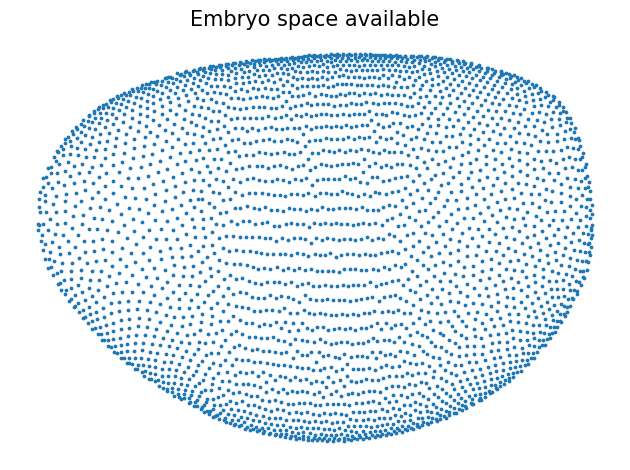

In [6]:
tit_size = 15
dpi = 100
#fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=dpi)

plt.scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)
#ax[1].scatter(locations_from_image[:, 0], locations_from_image[:, 1], s=3)
#ax[2].scatter(locations_circle[:, 0], locations_circle[:, 1], s=3)

plt.title('Embryo space available', size=tit_size)
#ax[1].set_title('Prior shape without exact locations', size=tit_size)
#ax[2].set_title('No prior knowledge of target space', size=tit_size)

plt.axis('off')
#ax[1].axis('off')
#ax[2].axis('off')

plt.tight_layout()
plt.show()

In [7]:
tissue.setup_smooth_costs

NameError: name 'tissue' is not defined

## Reconstruct the tissue and visualize average gene expression

In [ ]:
#dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
#sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)
num_neighbors_s = num_neighbors_t = 5

# tissue.setup_reconstruction(num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# alternative: since we don't have the atlas assumption, we can also setup only the smooth costs.
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)
tissue.reconstruct(alpha_linear=0, epsilon=5e-3)
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=dataset.var.index.tolist()))
dataset_reconst.obsm['spatial'] = locations_apriori

In [ ]:
results = pd.read_csv("../../data/GraphComm_Output/Drosophila/CCI.csv",index_col=0)
#results = pd.merge(results,intercell,left_on=["Src","Dst"],right_on=["source","target"])
#results = results.head(1000)

In [ ]:
resource = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [ ]:
results[results["Src"].isin(resource["source"].tolist()) & results["Dst"].isin(resource["target"].tolist())]

## top ranked interaction

In [ ]:
dataset = dataset_reconst
color = ["PCNA"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

In [ ]:
dataset = dataset_reconst
color = ["LAMP1"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=tit_size)
    plt.colorbar(plot)
plt.show()

In [ ]:
dataset = dataset_reconst
color = ["WNT4"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=13)
    plt.colorbar(plot)
#plt.tight_layout()
plt.show()

In [ ]:
dataset = dataset_reconst
color = ["PDE1C"]
title=None
size_x=None
size_y=None
pt_size=10
tit_size=15
dpi=100

new_matrix = pd.DataFrame(dataset_reconst.X)
new_matrix.columns = dataset.var.index.tolist()
new_matrix.index = dataset.obs.index.tolist()
new_matrix = new_matrix.loc[:,~new_matrix.columns.duplicated()].copy()
new_matrix["avg"]=new_matrix.sum(axis=1)
new_dataset = anndata.AnnData(new_matrix)
new_dataset.obsm = dataset.obsm
dataset = new_dataset


title = color if title is None else title
ncolor = len(color)
per_row = 3
per_row = ncolor if ncolor < per_row else per_row
nrows = int(np.ceil(ncolor / per_row))
size_x = 5 * per_row if size_x is None else size_x
size_y = 3 * nrows if size_y is None else size_y
fig, axs = plt.subplots(nrows, per_row, figsize=(size_x, size_y), dpi=dpi)
xy = dataset.obsm['spatial']
x = xy[:, 0]
y = xy[:, 1] if xy.shape[1] > 1 else np.ones_like(x)
for i, g in enumerate(color):
    if g in dataset.var_names:
        values = dataset[:, g].X
    elif g in dataset.obs.columns:
        values = dataset.obs[g]
    else:
        continue
    indices = np.where(values > np.mean(values))[0]
    plot = plt.scatter(x, y, c=np.array(values), s=pt_size)
    plt.title(f"Distribution of {color[0]} expression", size=12)
    plt.colorbar(plot)
plt.show()

# Dataset 2: Mouse brain dataset (Figure 4)

In [42]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [43]:
consensus = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [44]:
mouse_intercell = intercell[intercell["references"].str.contains("Ramilowski")]

In [45]:
input_data=pd.read_csv("../../data/GraphComm_Output/Mouse/CCI.csv")

In [46]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]

In [47]:
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [48]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [49]:
input_data = input_data[input_data["Src"].isin(intercell["source_genesymbol"])]

In [50]:
input_data = input_data[input_data["Dst"].isin(intercell["target_genesymbol"])]

In [51]:
total_nodes = pd.read_csv("/data/GraphComm_Input/Mouse/nodes.csv")
consensus_nodes = pd.read_csv("/data/GraphComm_Input/consensus_Mouse/nodes.csv")

In [52]:
input_data = input_data.head(100)

In [53]:
input_data.index = range(0,input_data.shape[0])

In [54]:
input_data[input_data["Src"]=="LAMA4"]

,Unnamed: 0,Src,Dst,Prob


In [55]:
total_ligands = total_nodes[total_nodes["category"]=="Ligand"]["identifier"].unique().tolist()
total_receptors = total_nodes[total_nodes["category"]=="Receptor"]["identifier"].unique().tolist()
consensus_ligands = consensus_nodes[consensus_nodes["category"]=="Ligand"]["identifier"].unique().tolist()
consensus_receptors = consensus_nodes[consensus_nodes["category"]=="Receptor"]["identifier"].unique().tolist()

In [56]:
total_ligands = [i.split("_")[0] for i in total_ligands]
total_receptors = [i.split("_")[0] for i in total_receptors]
consensus_ligands = [i.split("_")[0] for i in consensus_ligands]
consensus_receptors = [i.split("_")[0] for i in consensus_receptors]

In [57]:
total_ligands = [i for i in total_ligands if i in intercell["source_genesymbol"].tolist()]
total_receptors = [i for i in total_receptors if i in intercell["target_genesymbol"].tolist()]

In [58]:
truth_total_ligands = [i for i in truth["Ligand"].unique().tolist() if i not in total_ligands]
truth_total_receptors = [i for i in truth["Receptor"].unique().tolist() if i not in total_receptors]
truth_consensus_ligands = [i for i in truth["Ligand"].unique().tolist() if i not in consensus_ligands]
truth_consensus_receptors = [i for i in truth["Receptor"].unique().tolist() if i not in consensus_receptors]

In [59]:
matrix = pd.read_csv("/data/GraphComm_Input/Mouse/matrix.csv",index_col=0)

In [60]:
ligands = [i for i in truth["Ligand"].unique().tolist() if i in matrix.index.tolist()]
receptors = [i for i in truth["Receptor"].unique().tolist() if i in matrix.index.tolist()]

In [61]:
intersect_total_ligands = list(set(ligands)&set(truth_total_ligands))
intersect_total_receptors = list(set(receptors)&set(truth_total_receptors))
intersect_consensus_ligands = list(set(ligands)&set(truth_consensus_ligands))
intersect_consensus_receptors = list(set(receptors)&set(truth_consensus_receptors))

In [62]:
random_list = []
for i in range(1,101):
    random_list.append(pd.read_csv(f"/data/random_data/Mouse/candidate_Mouse_{i}_random.csv",index_col=0))

In [63]:
random_list = [i.drop_duplicates() for i in random_list]

In [64]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [65]:
random_list = [i.sort_values("Prob",ascending=False) for i in random_list]

In [66]:
new_random_list = []
for i in random_list:
    i.columns = ["Src","Dst","Prob"]
    new_random_list.append(i)

In [67]:
random_list = new_random_list

In [68]:
random_list = [i[["Src","Dst","Prob"]] for i in random_list]

In [69]:
random_list = [i[i["Src"].isin(intercell["source_genesymbol"])] for i in random_list]

In [70]:
random_list = [i[i["Dst"].isin(intercell["target_genesymbol"])] for i in random_list]

In [71]:
random_list = [i.head(100) for i in random_list]

In [72]:
total_random = pd.concat(random_list)

In [73]:
total_random.groupby("Dst").count().sort_values("Prob",ascending=False)

,Src,Prob
Dst,,
IL13RA1,166,166
ESRRA,138,138
CXADR,123,123
UNC5C,122,122
TYK2,107,107
...,...,...
LPP,7,7
HSPA8,7,7
THRA,7,7


In [74]:
random_dfs = random_list

In [75]:
important_ligands = truth["Ligand"].unique().tolist()
important_receptors = truth["Receptor"].unique().tolist()

In [76]:
graphcomm_LR_list = []
for i in range(5,101,5):
    temp= input_data.head(i)
    ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
    receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
    graphcomm_LR_list.append((np.sum(ligands)+np.sum(receptors))/(i*2))
random_LR_list = []
for i in random_dfs:
    sub_random = i
    sub_random_list = []
    for j in range(5,101,5):
        temp= sub_random.head(j)
        ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
        receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
        sub_random_list.append((np.sum(ligands)+np.sum(receptors))/(j*2))
    random_LR_list.append(sub_random_list)

In [77]:
mean_random_LR_list = list(np.mean(random_LR_list,axis=0))

In [78]:
graphcomm_LR_list = [0] + graphcomm_LR_list
mean_random_LR_list = [0] + mean_random_LR_list

Text(0, 0.5, 'Fraction of interactions containing relevant ligands/receptors')

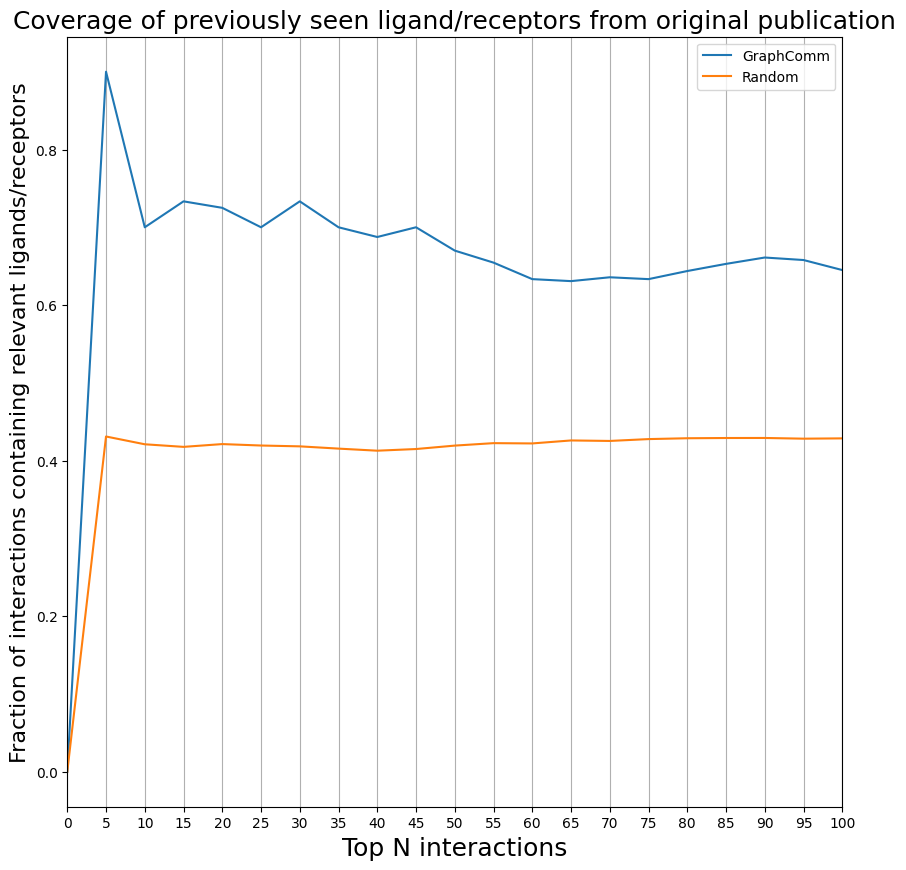

In [85]:
figure(figsize=(10,10))

plt.plot(range(0,101,5),graphcomm_LR_list,label="GraphComm")
plt.plot(range(0,101,5),mean_random_LR_list,label="Random")
plt.grid(axis = 'x')
plt.xticks(range(0,101,5))
plt.xlim((0,100))
#plt.ylim((0,10))
plt.legend()
plt.title("Coverage of previously seen ligand/receptors from original publication",fontdict={'fontsize':18})
plt.xlabel("Top N interactions",fontdict={'fontsize':18})
plt.ylabel("Fraction of interactions containing relevant ligands/receptors",fontdict={'fontsize':16})
#plt.savefig("/results/cdf.png")

# Dataset 3:scRNA PC9 cell line dataset with drug treatment - change comparison datasets to generate pre/post or biological replicate overlap (Figure 5)

### load datasets

In [86]:
day0=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day0/CCI.csv",index_col=0)
day7_rep1=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day7_1/CCI.csv",index_col=0)
day7_rep2=pd.read_csv("../../data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv",index_col=0)

In [87]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [88]:
Omnipath_database.columns = ["from","to","sources"]


### only retain, within each dataset, **validated intercell interactions from Omnipath**

In [89]:
day0=pd.merge(day0,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep1=pd.merge(day7_rep1,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep2=pd.merge(day7_rep2,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()

In [90]:
day0.head(100).groupby("Src").count().sort_values("Dst",ascending = True)

,Dst
Src,
LGALS3,1
LAMA2,1
LAMB2,1
WNT5A,1
MICA,1
...,...
NRG1,3
NGF,3
APOE,3


### find the number of common interactions within the top 100 between biological replicates (and save that value for the randomization experiment)

In [91]:
only_day7_1_ligands = day7_rep1[(~day7_rep1["Src"].isin(day0["Src"].tolist())) & (day7_rep1["Src"].isin(day7_rep2["Src"].tolist()))]
only_day7_1_receptors = day7_rep1[(~day7_rep1["Dst"].isin(day0["Dst"].tolist())) & (day7_rep1["Dst"].isin(day7_rep2["Dst"].tolist()))]

In [92]:
common = pd.merge(day7_rep1.head(50),day7_rep2.head(50))

In [93]:
original_accuracy = common.shape[0]/50

### use a stacked bar plot to visualize the commonalities

In [94]:
original_accuracy

0.56

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

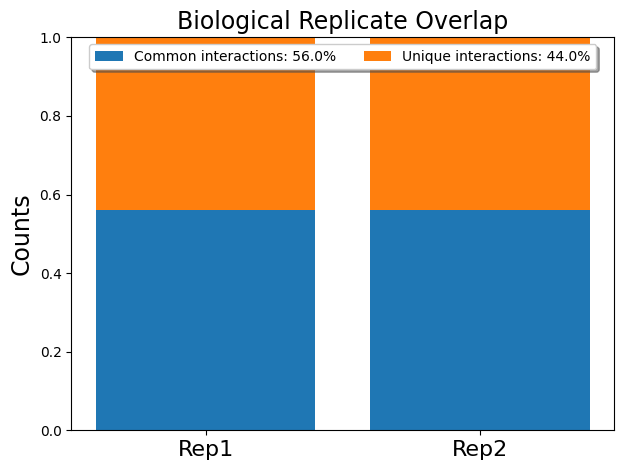

In [116]:
%matplotlib inline
labels = ["Rep1","Rep2"]
men_means = [round(common.shape[0]/50,3),round(common.shape[0]/50,3)]
women_means = [1- round(common.shape[0]/50,3),1- round(common.shape[0]/50,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/50*100,2)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/50*100,3),2)}%")

ax.set_ylabel("Counts",fontsize=17)
ax.set_title("Biological Replicate Overlap",fontdict={"fontsize":17})
plt.xticks(fontsize=16)
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True,fontsize=10)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


### find the number of common interactions within the top 100 between pre and post treatment datasets (and save that value for the randomization experiment)

In [117]:
pre_post_common = pd.merge(day0.head(50),day7_rep1.head(50))

In [118]:
pre_post_common.shape[0]/50

0.16

### use a stacked bar plot to visualize the commonalities

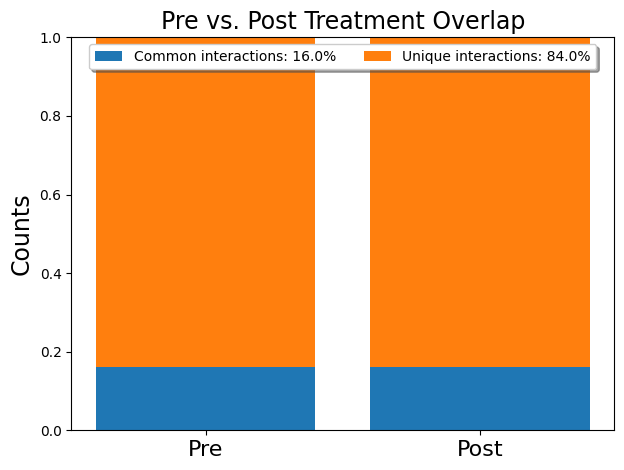

In [120]:
%matplotlib inline
labels = ["Pre","Post"]
men_means = [round(pre_post_common.shape[0]/50,3),round(pre_post_common.shape[0]/50,3)]
women_means = [1- round(pre_post_common.shape[0]/50,3),1- round(pre_post_common.shape[0]/50,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(pre_post_common.shape[0]/50*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(pre_post_common.shape[0]/50*100,3),2)}%")

ax.set_ylabel("Counts",fontsize=17)
ax.set_title("Pre vs. Post Treatment Overlap",fontdict={"fontsize":17})
plt.xticks(fontsize=16)

ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


In [131]:
difference_accuracy = original_accuracy - pre_post_common.shape[0]/50

In [132]:
df = pd.merge(common, pre_post_common, on=['Src','Dst'], how='left', indicator='Exist')

## Compare difference between overlap biological replicates vs. pre and post for Original Set and 100 Randomized Interactions

### load the datasets

In [133]:
rep1_list = []
rep2_list = []
day_0_list = []
for i in range(0,100):
    day_0_list.append(pd.read_csv(f"/data/random_data/Pre_Post/final_Day0_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep1_list.append(pd.read_csv(f"/data/random_data/Pre_Post/final_Rep1_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep2_list.append(pd.read_csv(f"/data/random_data/Pre_Post/final_Rep2_{i+1}_random.csv",index_col=0)[["Src","Dst"]])

In [134]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)[["source_genesymbol","target_genesymbol"]].drop_duplicates()
Omnipath_database.columns = ["from","to"]

#### within each randomized Rep1 and Rep2, subset for validated intercell interactions

In [135]:
day_0_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in day_0_list]

In [136]:
rep1_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep1_list]

In [137]:
rep2_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep2_list]

In [138]:
day_0_list = [i[["Src","Dst"]] for i in day_0_list]
rep1_list = [i[["Src","Dst"]] for i in rep1_list]
rep2_list = [i[["Src","Dst"]] for i in rep2_list]

In [139]:
rep_merged_list = [pd.merge(i.head(50),j.head(50)) for i,j in zip(rep1_list,rep2_list)]

In [140]:
pre_post_merged_list = [pd.merge(i.head(50),j.head(50)) for i,j in zip(day_0_list,rep2_list)]

### find the difference in overlap between each biological replicates and pre and post treatment

In [141]:
difference_list = [abs((i.shape[0]/50) - (j.shape[0]/50)) for i,j in zip(rep_merged_list,pre_post_merged_list)]

Text(0, 0.5, 'Count')

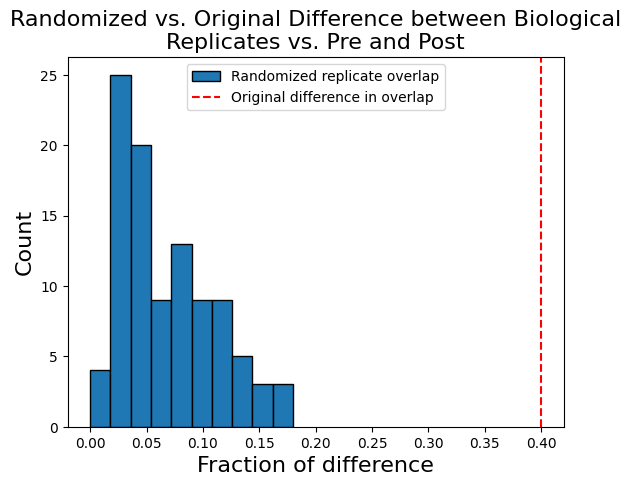

In [147]:
plt.hist(difference_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(difference_accuracy,linestyle="--",color="red",label="Original difference in overlap")
plt.title("Randomized vs. Original Difference between Biological\nReplicates vs. Pre and Post",fontdict={'fontsize':16})
plt.legend()
plt.xlabel("Fraction of difference",fontsize=16)
plt.ylabel("Count",fontsize=16)

## Compare overlap between biological replicates for Original Set and 100 Randomized Interactions

### find the fraction of overlap between each set of replicates

In [148]:
accuracy_list = [i.shape[0]/50 for i in rep_merged_list]

In [149]:
accuracy_list.index(min(accuracy_list))

4

In [150]:
pd.merge(rep1_list[4].head(50),rep2_list[4].head(50))

,Src,Dst
0,MDK,SDC1
1,TP53,SLC38A2
2,GHRL,GPR39
3,CCL25,ACKR2
4,CCL5,CCR3
5,S100A9,CD68
6,MICA,HCST
7,HLA-B,KLRD1
8,CCL2,CCR10
9,TP53,ODC1


Text(0, 0.5, 'Count')

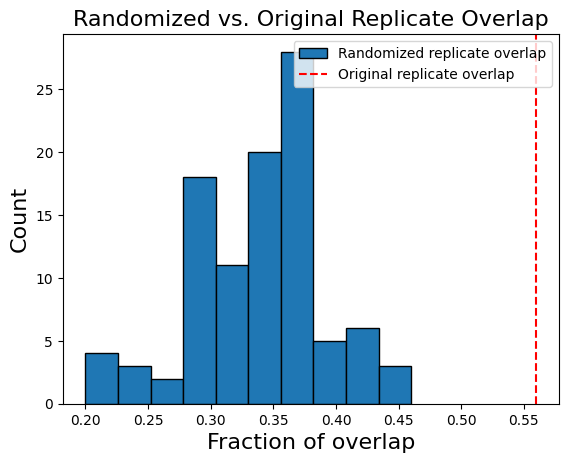

In [151]:
plt.hist(accuracy_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(original_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Replicate Overlap",fontdict={'fontsize':16})
plt.legend(loc="upper right")
plt.xlabel("Fraction of overlap",fontsize=16)
plt.ylabel("Count",fontsize=16)

# Dataset 5: Spatial Cardiovascular Data (Figure 6 & 7)

## Find most common interacting cell groups and spatial adjacency across all fibrotic and ischemic slides (Fig 4 B-G)

In [152]:
fibrotic_list = []
for i in os.listdir("../../data/GraphComm_Output/Cardiac_cells/"):
    if "FZ" in i:
        temp_df = pd.read_csv(f"../../data/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        fibrotic_list.append(temp_df)
fibrotic_CCI = pd.concat(fibrotic_list)

In [153]:
ischemic_list = []
for i in os.listdir("../../data/GraphComm_Output/Cardiac_cells/"):
    if "IZ" in i:
        temp_df = pd.read_csv(f"../../data/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        ischemic_list.append(temp_df)
ischemic_CCI = pd.concat(ischemic_list)

## remove self-loops

In [154]:
fibrotic_list = [i[i["Src Cell"] != i["Dst Cell"]] for i in fibrotic_list]
ischemic_list = [j[j["Src Cell"] != j["Dst Cell"]] for j in ischemic_list]

## from each slide, retain the top 100 interactions

In [155]:
fibrotic_CCI = pd.concat(fibrotic_list)
ischemic_CCI = pd.concat(ischemic_list)

In [156]:
fibrotic_CCI = pd.concat([i.head(100) for i in fibrotic_list])
ischemic_CCI = pd.concat([i.head(100) for i in ischemic_list])

In [157]:
fibrotic_CCI = fibrotic_CCI.sort_values("Prob",ascending=False)
ischemic_CCI = ischemic_CCI.sort_values("Prob",ascending=False)

In [158]:
fibrotic_cell_groups = list(set(fibrotic_CCI["Src Cell"].unique().tolist() + fibrotic_CCI["Dst Cell"].unique().tolist()))
ischemic_cell_groups = list(set(ischemic_CCI["Src Cell"].unique().tolist() + ischemic_CCI["Dst Cell"].unique().tolist()))

In [159]:
fibrotic_matrix = pd.DataFrame(index=fibrotic_cell_groups,columns=fibrotic_cell_groups)
ischemic_matrix = pd.DataFrame(index=ischemic_cell_groups,columns=ischemic_cell_groups)

In [160]:
fibrotic_CCI = fibrotic_CCI[["Src Cell","Dst Cell","Prob"]]
ischemic_CCI = ischemic_CCI[["Src Cell","Dst Cell","Prob"]]

In [161]:
fibrotic_CCI = fibrotic_CCI.groupby(["Src Cell","Dst Cell"]).count()
ischemic_CCI = ischemic_CCI.groupby(["Src Cell","Dst Cell"]).count()

In [162]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [163]:
for index,row in fibrotic_CCI.iterrows():
    fibrotic_matrix.loc[index[0],index[1]] += row["Prob"]
    fibrotic_matrix.loc[index[1],index[0]] += row["Prob"]

In [164]:
for index,row in ischemic_CCI.iterrows():
    ischemic_matrix.loc[index[0],index[1]] += row["Prob"]
    ischemic_matrix.loc[index[1],index[0]] += row["Prob"]

In [165]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [166]:
fibrotic_matrix

,Myeloid,Endothelial,Pericyte,Cycling.cells,vSMCs,Neuronal,Cardiomyocyte,Fibroblast,Mast
Myeloid,0,14,0,25,108,5,0,4,4
Endothelial,14,0,0,10,22,1,0,3,3
Pericyte,0,0,0,0,39,0,0,0,0
Cycling.cells,25,10,0,0,44,100,11,10,43
vSMCs,108,22,39,44,0,36,26,13,46
Neuronal,5,1,0,100,36,0,0,3,1
Cardiomyocyte,0,0,0,11,26,0,0,0,26
Fibroblast,4,3,0,10,13,3,0,0,3
Mast,4,3,0,43,46,1,26,3,0


In [167]:
import numpy as np

In [168]:
import seaborn as sns

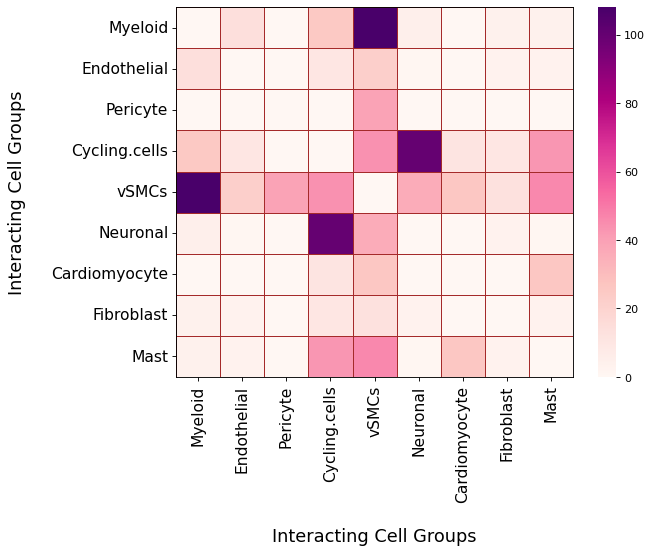

In [180]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(fibrotic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("\nInteracting Cell Groups",fontdict={'fontsize':16})
ax.set_ylabel("Interacting Cell Groups\n",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for _, spine in ax.spines.items():
    spine.set_visible(True)

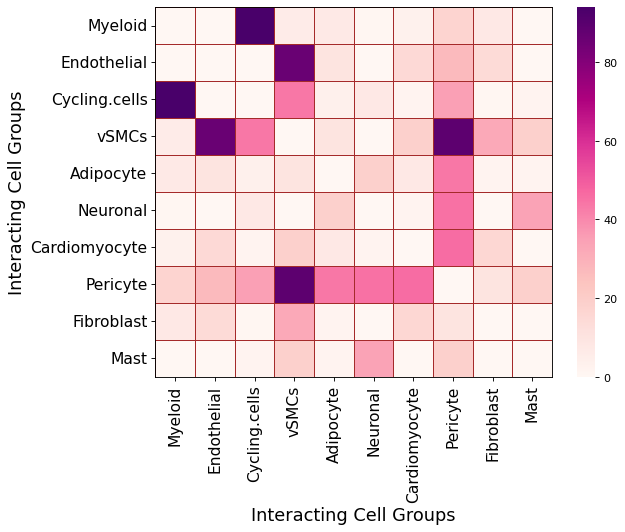

In [181]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(ischemic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups",fontdict={'fontsize':16})
ax.set_ylabel("Interacting Cell Groups",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Comparison of spatial adjacency in a given fibrotic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [182]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [183]:
groups = ["vSMCs","Myeloid"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [184]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

In [205]:
sc.set_figure_params(scanpy=True, fontsize=20,figsize=(7,7))

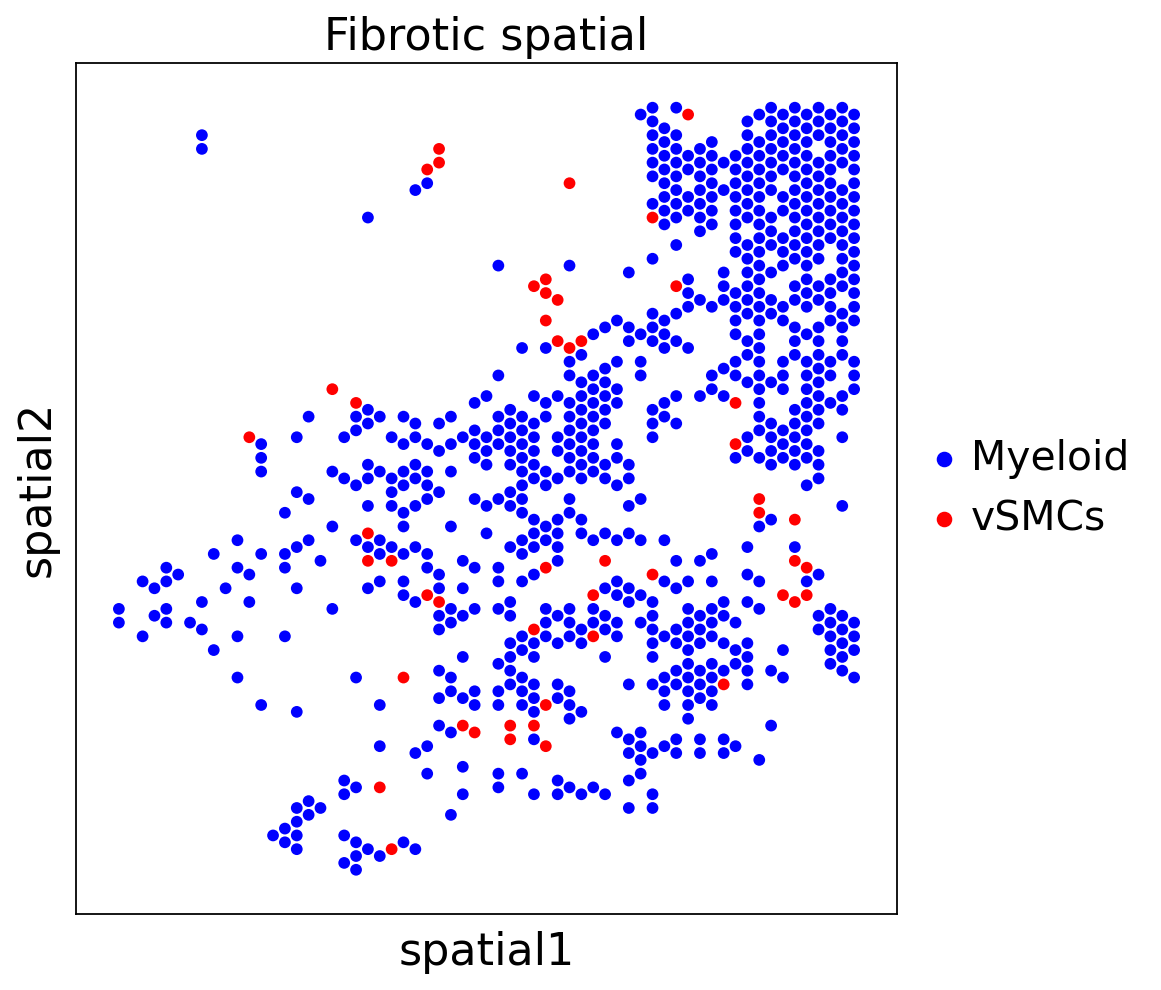

In [206]:
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",palette=colour_dict,title="Fibrotic spatial")

In [207]:
import math

In [208]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [209]:
groups = ["Myeloid","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [210]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-210-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [211]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [212]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [213]:
total_list = []
data_list = []
one = "vSMCs"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [214]:
data_list

[0.017507574481738505]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [215]:
fibrotic_ints = pd.concat(fibrotic_list)

In [216]:
one="Myeloid"
two="vSMCs"

In [217]:
fibrotic_ints = fibrotic_ints[((fibrotic_ints["Src Cell"]==one)&(fibrotic_ints["Dst Cell"]==two)) | ((fibrotic_ints["Dst Cell"]==one)&(fibrotic_ints["Src Cell"]==two))]

In [218]:
consensus = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [219]:
fibrotic_ints = pd.merge(fibrotic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

## Example visualization of scarce interaction

In [220]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [221]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [222]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


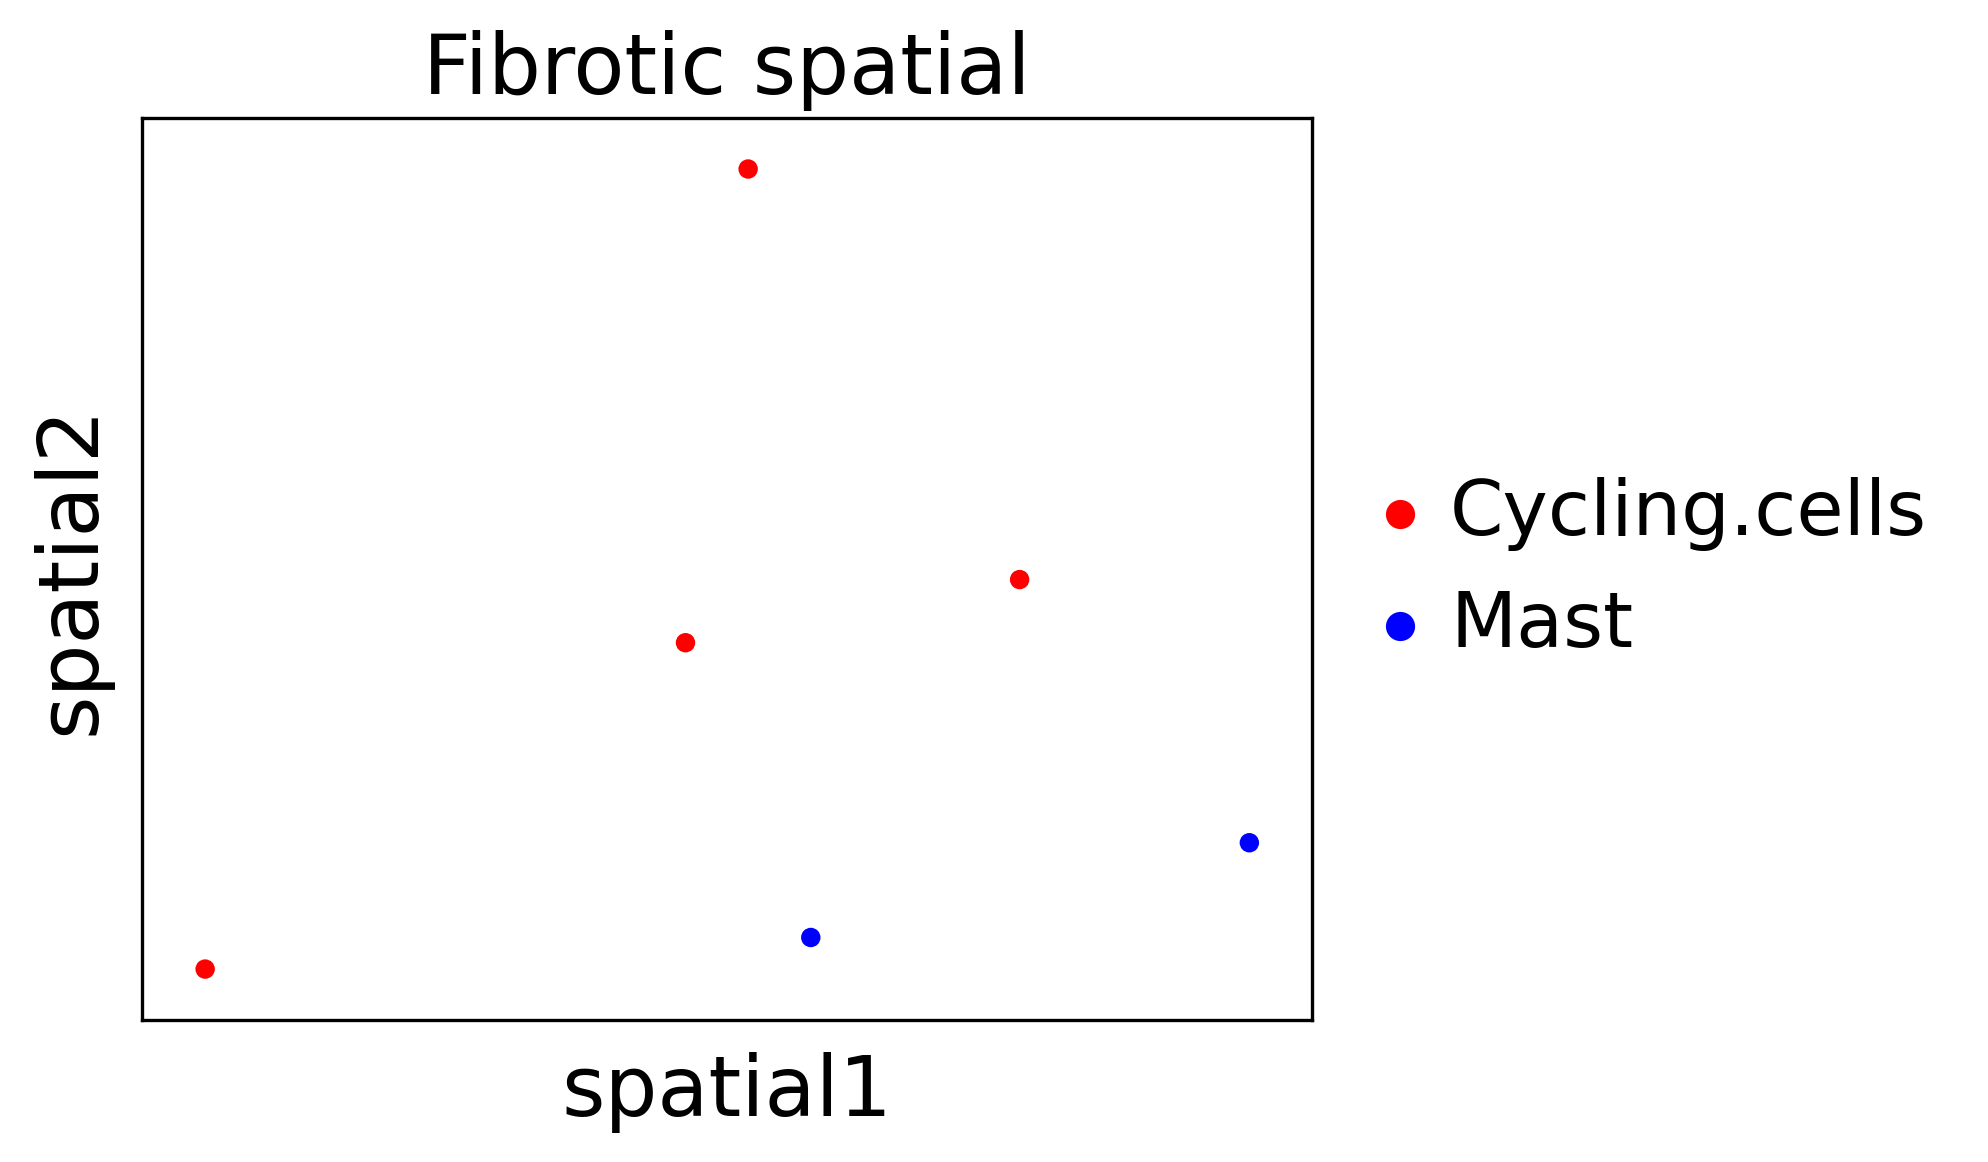

In [223]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [70]:
import math

In [224]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [225]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [226]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-226-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [227]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [228]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [229]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [230]:
data_list

[0.4886884308417194]

# Comparison of spatial adjacency in a given ischemic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [231]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-IZ_P3.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [232]:
groups = ["vSMCs","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [233]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


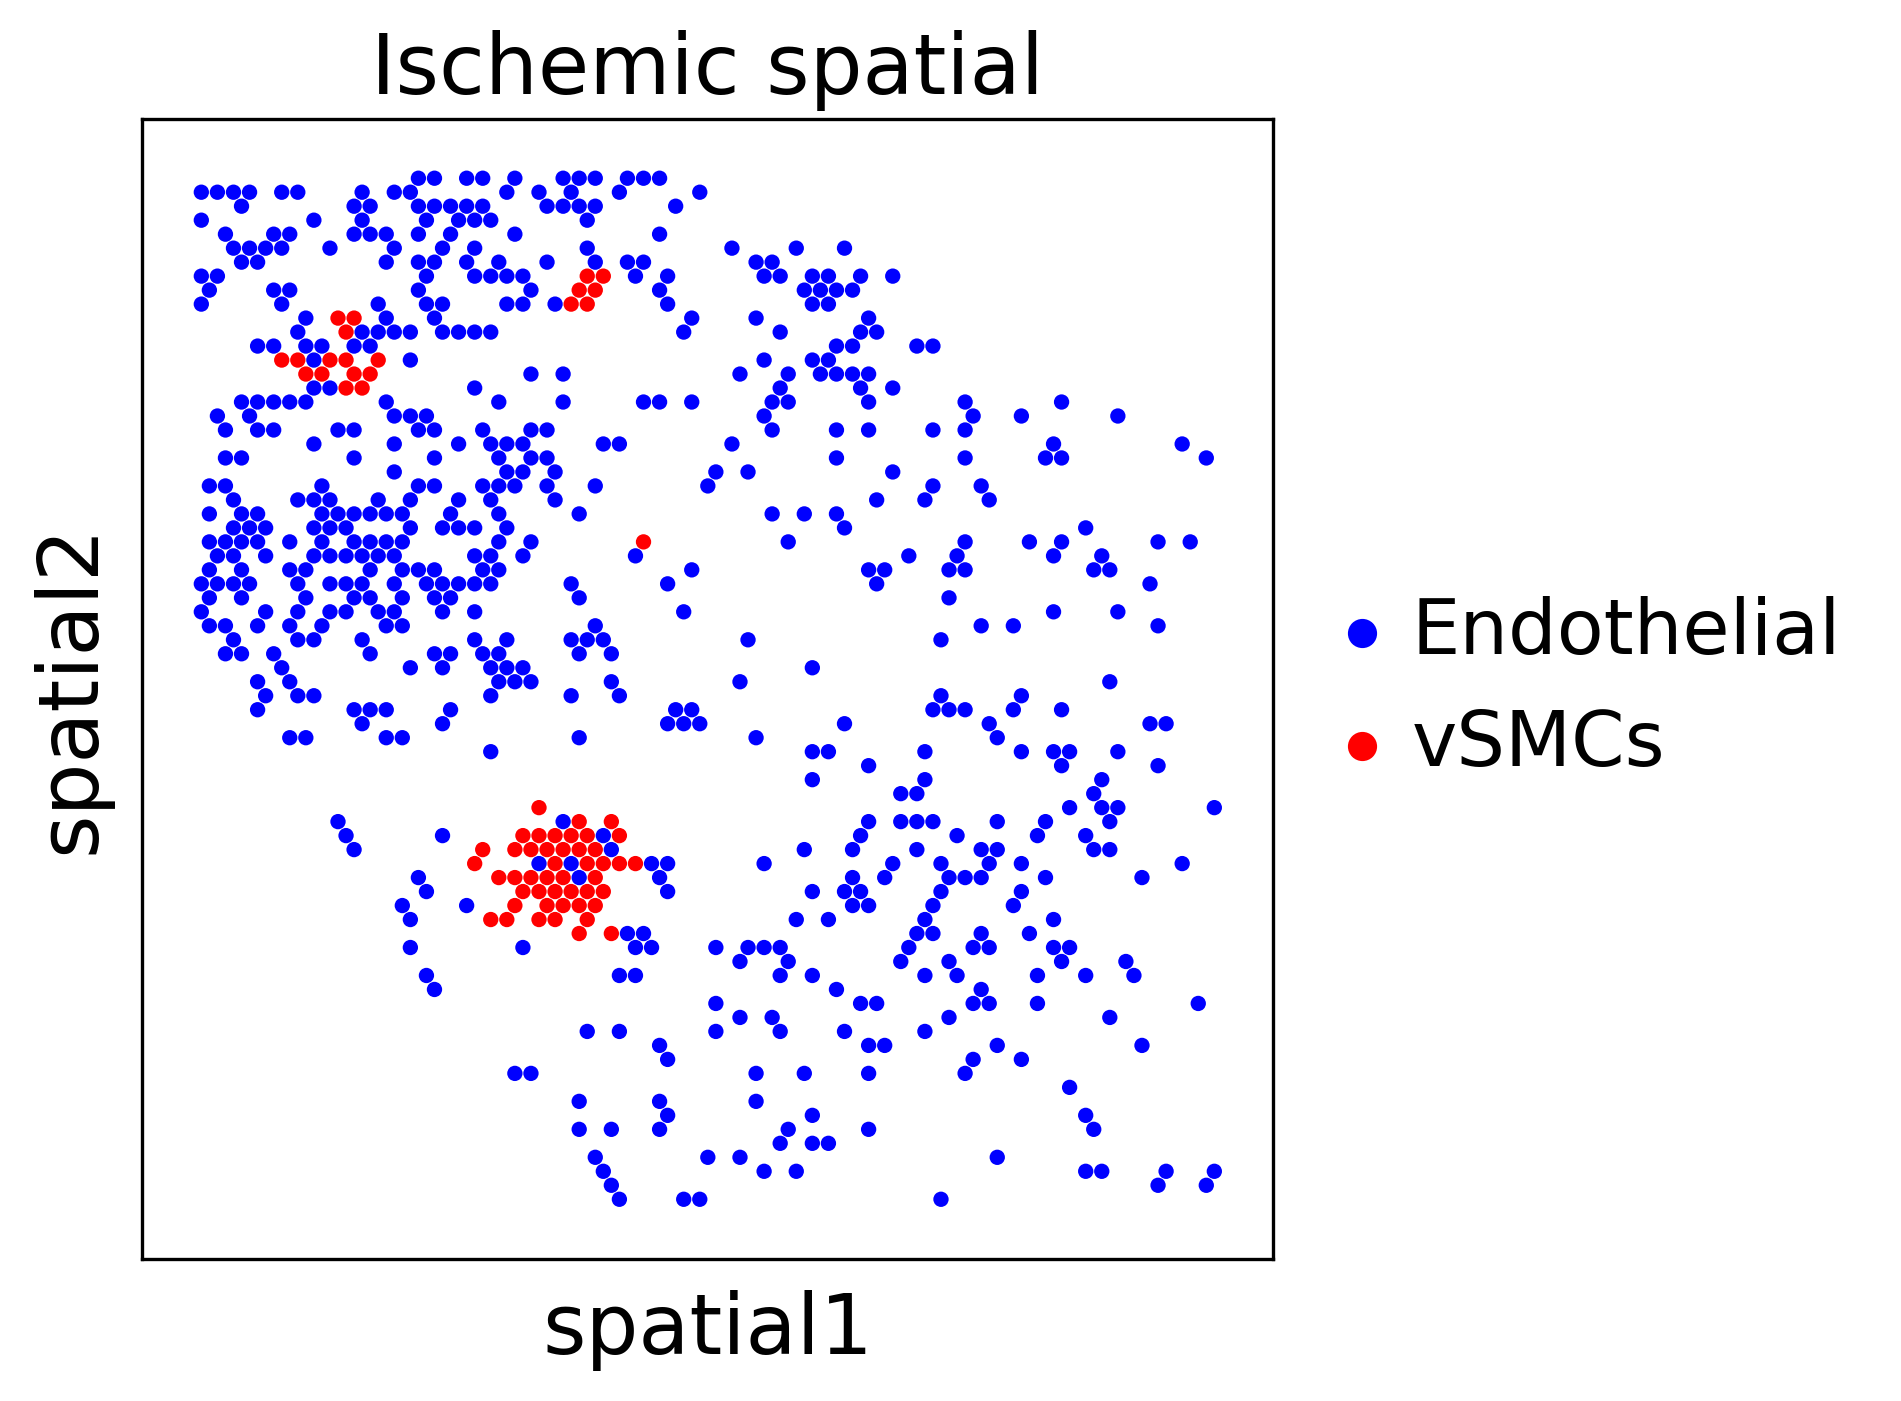

In [234]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",color_map="viridis",title="Ischemic spatial",palette=colour_dict)

In [235]:
import math

In [239]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_P3.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [240]:
groups = ["Endothelial","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [241]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-241-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [242]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [243]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [244]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [245]:
min_list

[0.45310975036404194,
 0.37906826648873876,
 0.6667265326829047,
 0.4821071393984399,
 0.5211302211503632,
 0.4688989635065742,
 0.46443097487854196,
 0.441900309438107,
 0.7124244394616293,
 0.43414572717453803,
 0.48545715666403744,
 0.3714781978111675,
 0.4873073579012737,
 0.3508867525789384,
 0.6091723810996729,
 0.4563331650146358,
 0.41596066595687625,
 0.5102498825625826,
 0.451481164059382,
 0.418509771143898,
 0.4612500343216264,
 0.5607177243570726,
 0.35197164373211615,
 0.6758159883345392,
 0.48015423960796755,
 0.5368314740895651,
 0.38022719096584817,
 0.36026393025306025,
 0.3768221506674389,
 0.4033466975497877,
 0.6264148869431663,
 0.5686981062706048,
 0.40663753481239195,
 0.44675260837670905,
 0.3828643799363802,
 0.36785519359068775,
 0.6823291314642779,
 0.41951186425166126,
 0.43769867378077726,
 0.48856453546537754,
 0.41354926560022637,
 0.4335003725219494,
 0.7912097135131956,
 0.6140443097652124,
 0.43978263555916486,
 0.6075025088072802,
 0.4589463588535409

## Example visualization of scarce interaction

In [246]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [247]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [248]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


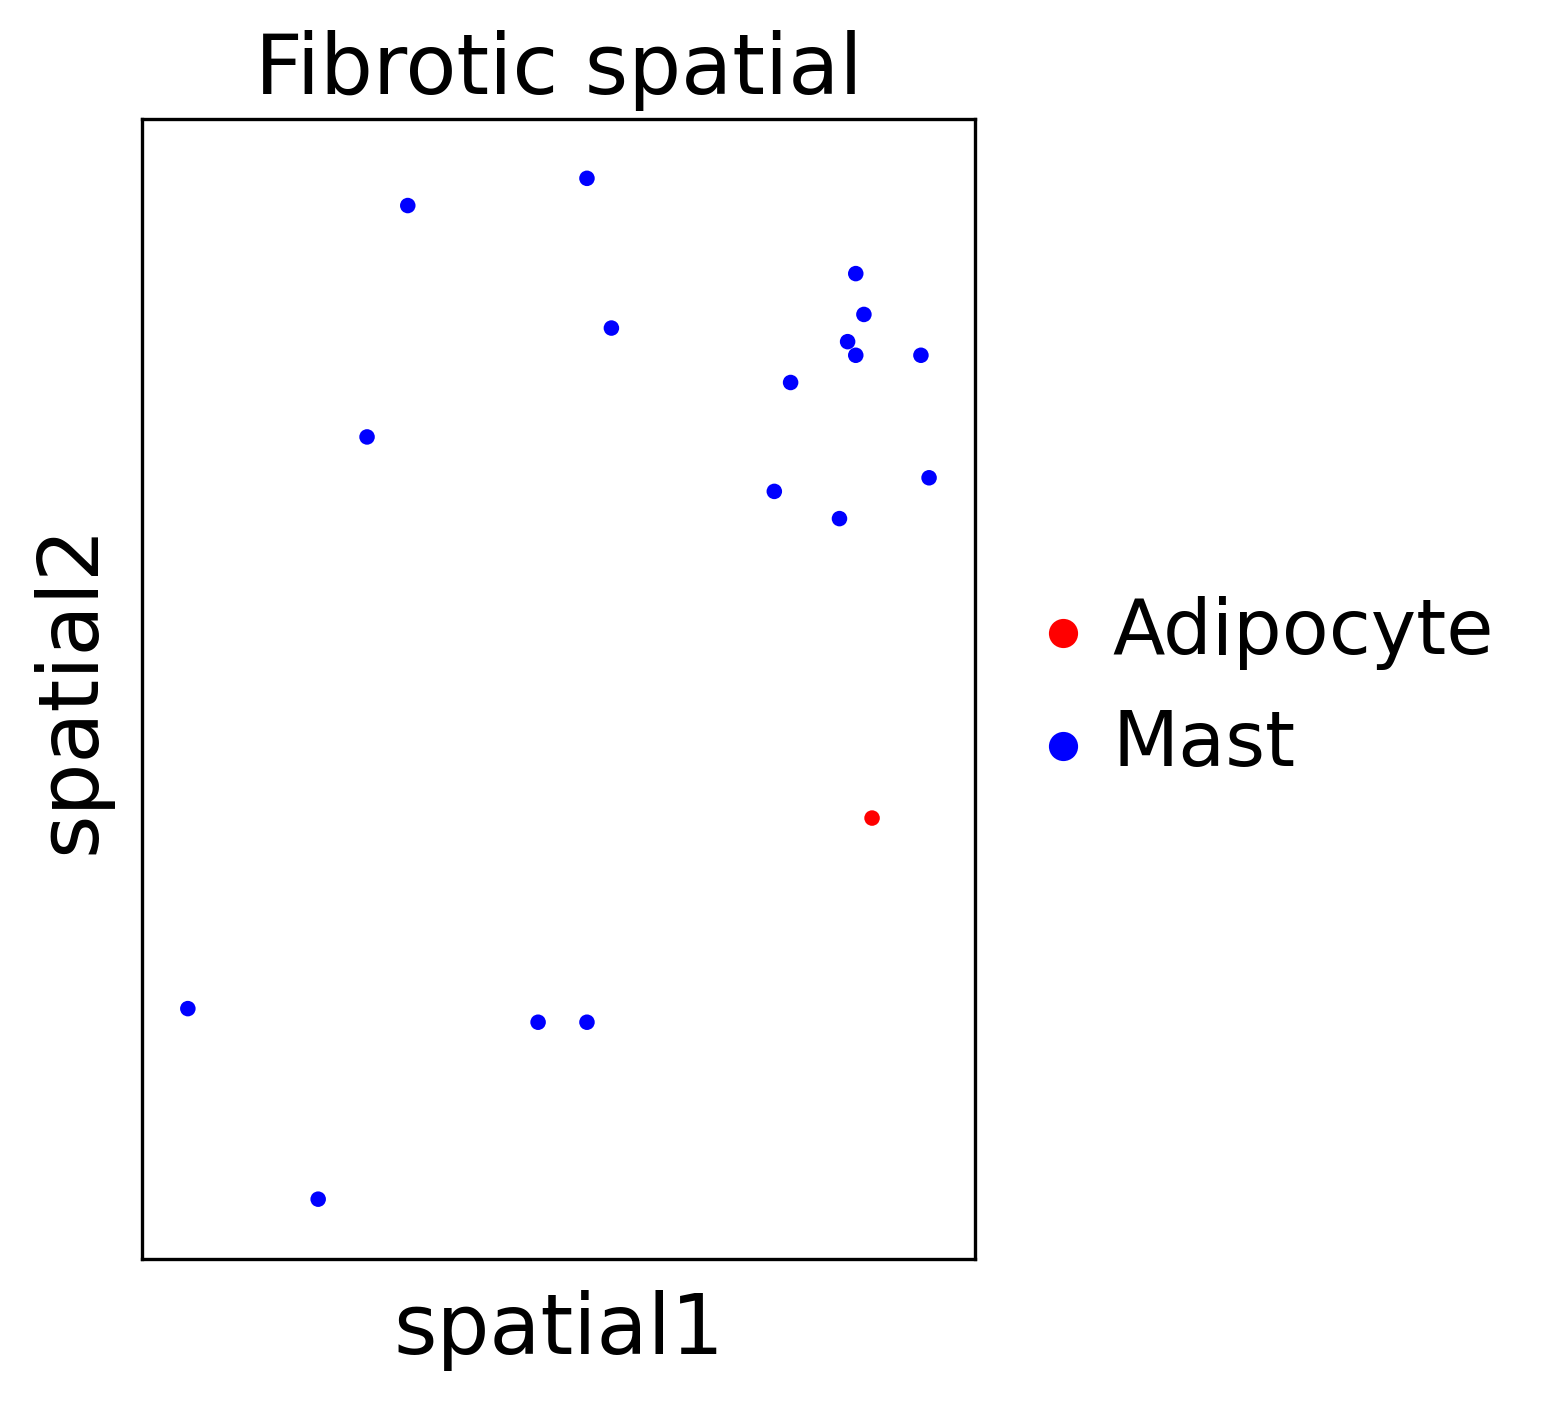

In [249]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [152]:
import math

In [153]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [154]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [155]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-155-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [156]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [157]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [158]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.min(min_list))


In [159]:
data_list

[0.38299058998724567]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [198]:
ischemic_ints = pd.concat(ischemic_list)

In [199]:
one="vSMCs"
two="Endothelial"

In [200]:
ischemic_ints = ischemic_ints[((ischemic_ints["Src Cell"]==one)&(ischemic_ints["Dst Cell"]==two)) | ((ischemic_ints["Dst Cell"]==one)&(ischemic_ints["Src Cell"]==two))]

In [201]:
consensus = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [202]:
ischemic_ints = pd.merge(ischemic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [203]:
ischemic_ints.sort_values("Prob",ascending=False).head(10)

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,references
0,SLIT3,ROBO4,0.957123,vSMCs,Endothelial,SLIT3,ROBO4,Cellinker:30288875;connectomeDB2020:19741192
47,VWF,SCARA5,0.934350,Endothelial,vSMCs,VWF,SCARA5,CellTalkDB:31126000
85,POMC,GPR20,0.905295,Endothelial,vSMCs,POMC,GPR20,CellTalkDB:32196115
33,EDN1,ADGRL4,0.903241,vSMCs,Endothelial,EDN1,ADGRL4,CellTalkDB:32196115
86,FGF13,SCN9A,0.897228,vSMCs,Endothelial,FGF13,SCN9A,SIGNOR:20679355
3,FGF13,SCN3A,0.858228,Endothelial,vSMCs,FGF13,SCN3A,SIGNOR:20679355
4,EBI3,IL27RA,0.858022,Endothelial,vSMCs,EBI3,IL27RA,Baccin2019:12121660;CellTalkDB:12121660;HPRD:1...
5,TGFB2,TGFBR3,0.856880,Endothelial,vSMCs,TGFB2,TGFBR3,Baccin2019:11157750;Baccin2019:12809600;CellTa...
54,FYN,PLD2,0.848639,Endothelial,vSMCs,FYN,PLD2,HPRD:12697812;KEA:15282299;KEA:9837959;SPIKE_L...
7,GSTO1,RYR1,0.819572,vSMCs,Endothelial,GSTO1,RYR1,CellTalkDB:11035031


# Analysis of single slide *FZ_GT_P19*

### visualize the total spatial map of tissue

In [250]:
input_data = pd.read_csv("../../data/GraphComm_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
input_data.index = range(0,input_data.shape[0])

In [251]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

### subset for **only validated intercell interactions**, and remove any self loops

In [252]:
#input_data = input_data[input_data["Src Cell"] != input_data["Dst Cell"]]
unique_groups = input_data.drop_duplicates(["Src Cell","Dst Cell"])

In [253]:
intercell_network = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [254]:
intercell_network.columns = ["source_genesymbol","target_genesymbol","refs"]

In [255]:
input_data[input_data["Src Cell"] == input_data["Dst Cell"]]

,Src,Dst,Prob,Src Cell,Dst Cell
8,ACTB,MT2A,0.964305,vSMCs,vSMCs
27,ACTB,UBB,0.870896,vSMCs,vSMCs
28,ACTB,DSTN,0.870562,vSMCs,vSMCs
30,ACTB,ACTA2,0.866390,vSMCs,vSMCs
34,ACTB,EPAS1,0.862109,vSMCs,vSMCs
...,...,...,...,...,...
6840154,SUV39H2,KCNJ3,0.019363,Cardiomyocyte,Cardiomyocyte
6840160,CNKSR1,GCK,0.019323,Cardiomyocyte,Cardiomyocyte
6840172,ESRRB,STX1A,0.019172,Fibroblast,Fibroblast
6840187,DSC1,KCNJ3,0.000102,Cardiomyocyte,Cardiomyocyte


## generate table for Cytoscape network

### list top ranked or low ranked interactions

## identify patterns in cell group interactions in only validated LR pairs

In [257]:
top_input = input_data.head(1000)

In [258]:
top_input = top_input.groupby(["Src Cell","Dst Cell"]).sum("Prob")

In [259]:
top_input

Prob
Src Cell Dst Cell                 
vSMCs    Cardiomyocyte   40.895089
         Endothelial     34.610029
         Fibroblast       3.601974
         Mast           118.617923
         Myeloid         16.289167
         Neuronal       165.157057
         Pericyte       176.068712
         vSMCs          115.904556

In [260]:
top_input = top_input.sort_values("Prob",ascending=False)

In [261]:
os.system("mkdir -p /results/GraphComm_Output/Cardiac_cells/")

0

In [262]:
top_input.to_csv("/results/GraphComm_Output/Cardiac_cells/FZ_GT_P19_grouped.csv")

## Visualize top ranked interaction

In [263]:
input_data = pd.merge(input_data,intercell_network,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [264]:
input_data.head(1000).groupby("Dst").count().sort_values("Prob",ascending=True)

,Src,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,refs
Dst,,,,,,,
ABCB1,1,1,1,1,1,1,1
NPTXR,1,1,1,1,1,1,1
NOS3,1,1,1,1,1,1,1
NCAM2,1,1,1,1,1,1,1
NAALAD2,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
LGMN,9,9,9,9,9,9,9
CTSF,9,9,9,9,9,9,9
DPP4,10,10,10,10,10,10,10


In [265]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [266]:
groups = ["Myeloid","vSMCs"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [267]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-267-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [269]:
sc.set_figure_params(scanpy=True, fontsize=20,figsize=(7,7))

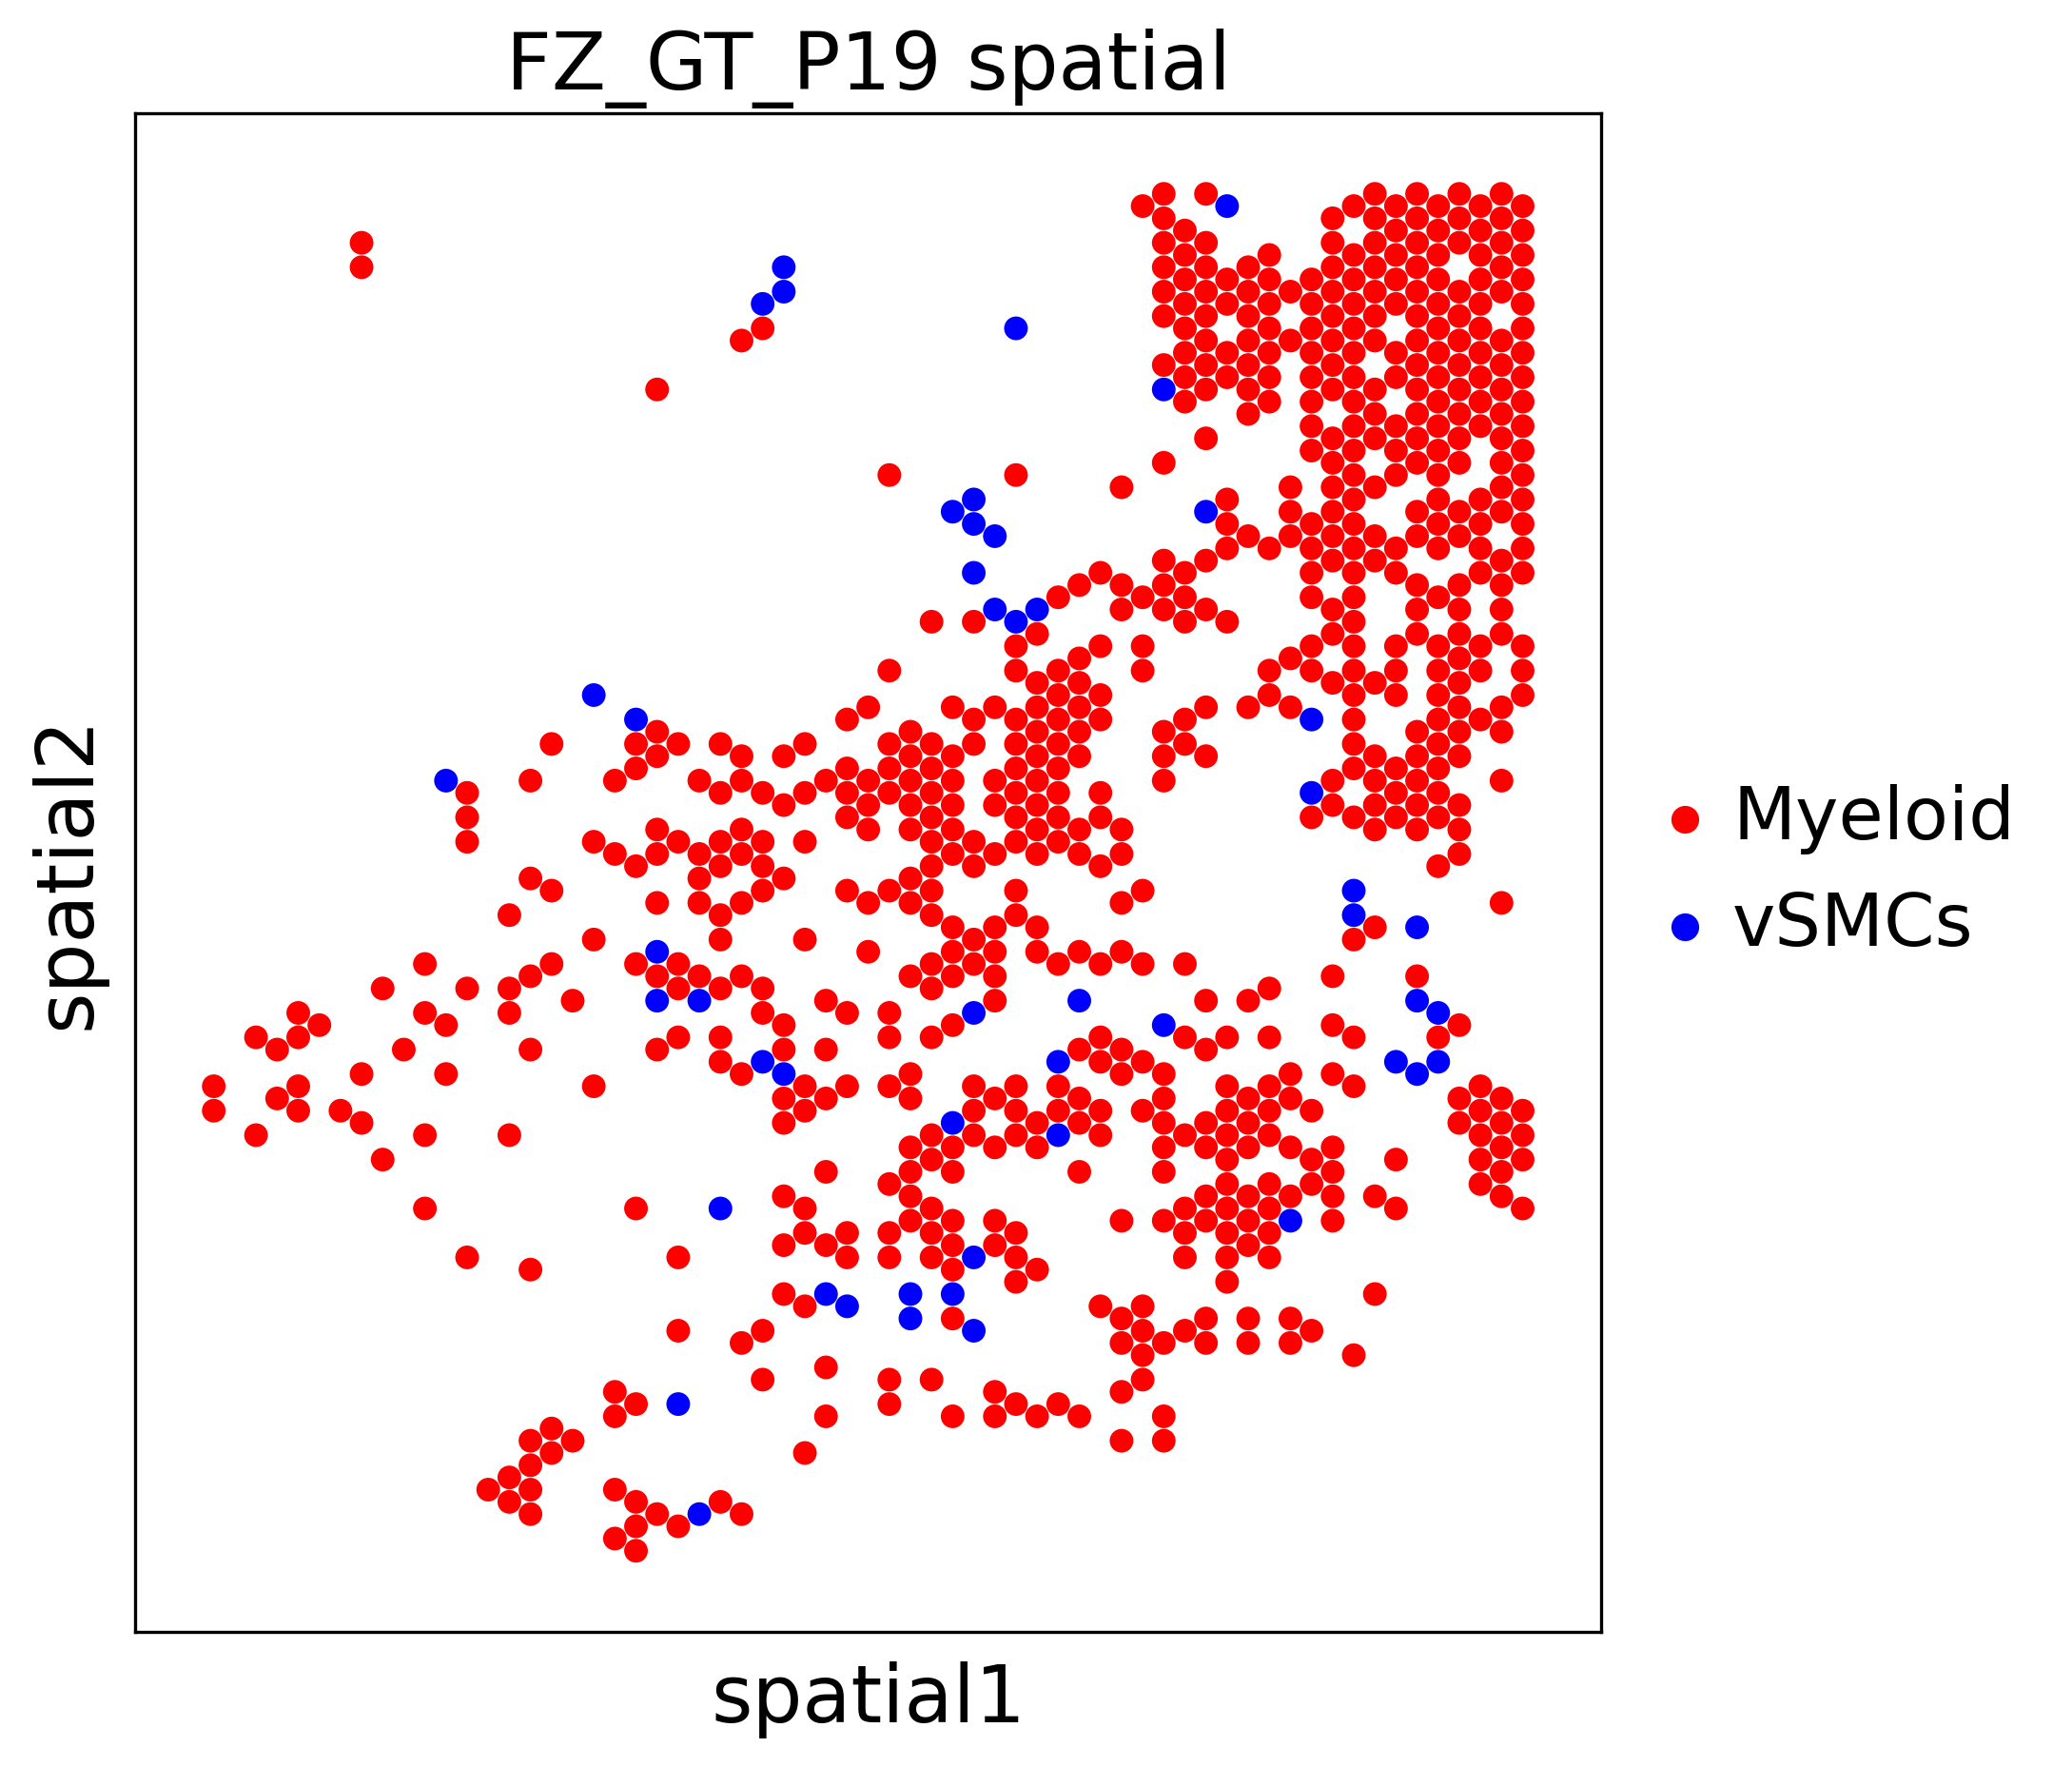

In [270]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [271]:
new_meta = meta[(meta["labels"]=="vSMCs") | (meta["labels"]=="Myeloid")]

In [272]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [273]:
one="vSMCs"
two="Myeloid"

In [274]:
relevant_input = input_data[((input_data["Src Cell"]==one)&(input_data["Dst Cell"]==two)) | ((input_data["Dst Cell"]==one)&(input_data["Src Cell"]==two))]






In [275]:
relevant_input

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,refs
32,HLA-B,SIGLEC10,0.267965,Myeloid,vSMCs,HLA-B,SIGLEC10,Cellinker:32822567
82,HP,CD163,0.198451,vSMCs,Myeloid,HP,CD163,CellTalkDB:25389409;HPRD:11854028;connectomeDB...
93,CXCL12,DPP4,0.188095,vSMCs,Myeloid,CXCL12,DPP4,CellTalkDB:30759373;Cellinker:11390394;HPRD:11...
188,SIGLEC9,ADGRA2,0.132870,Myeloid,vSMCs,SIGLEC9,ADGRA2,Cellinker:32822567
202,CD52,SIGLEC10,0.127698,Myeloid,vSMCs,CD52,SIGLEC10,Cellinker:23685786;LRdb:23685786;connectomeDB2...
211,KITLG,LRRN3,0.125011,vSMCs,Myeloid,KITLG,LRRN3,Cellinker:32589946
251,SIGLEC9,SIGLEC10,0.103594,Myeloid,vSMCs,SIGLEC9,SIGLEC10,Cellinker:32822567
253,ADCYAP1,DPP4,0.103202,vSMCs,Myeloid,ADCYAP1,DPP4,Cellinker:21314817
255,GDNF,GFRA3,0.102893,Myeloid,vSMCs,GDNF,GFRA3,CellTalkDB:32196115


## calculate mean eucledian distance between all spots of cell groups

In [276]:
import math

In [277]:
total_list = []
data_list = []
one = "vSMCs"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [278]:
data_list

[0.4208650761768496]

## Visualize low-ranked interaction

In [279]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [280]:
groups = ["Cardiomyocyte","Endothelial"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [281]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-281-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


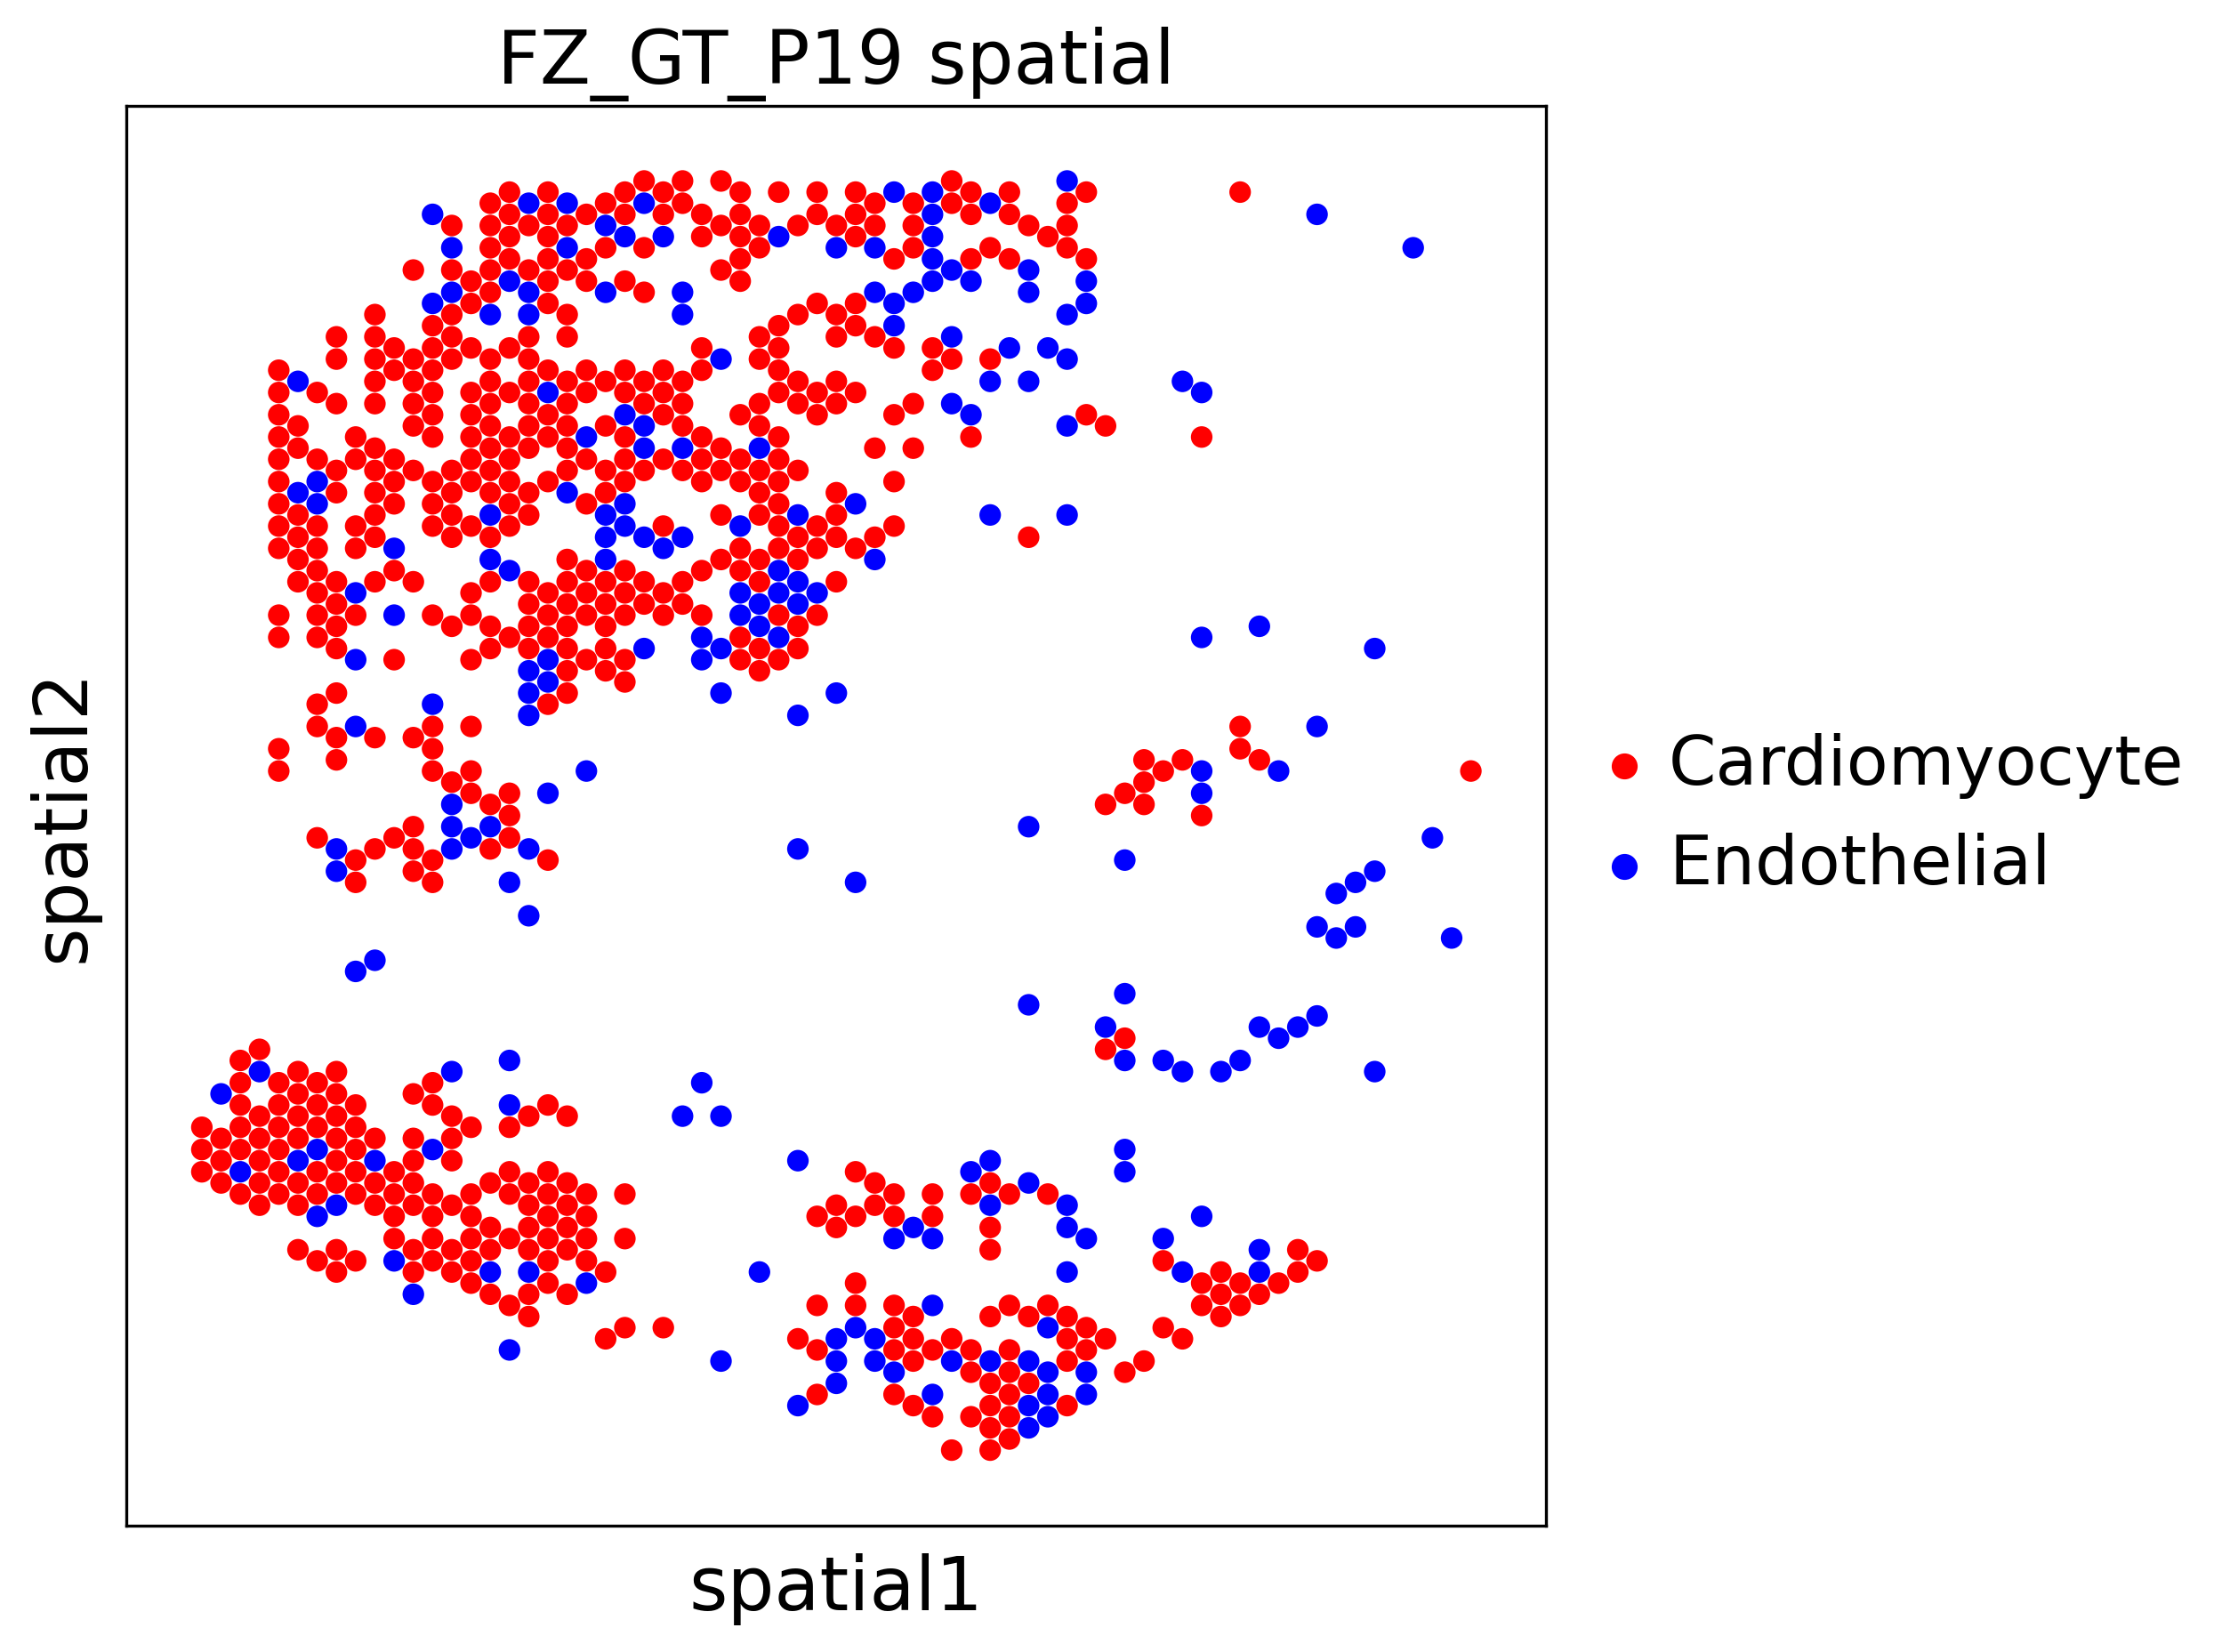

In [283]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [406]:
one = "Cardiomyocyte"
two = "Endothelial"

In [407]:
new_meta = meta[(meta["labels"]==one) | (meta["labels"]==two)]

In [408]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [409]:
import math

In [410]:
total_list = []
data_list = []
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.mean([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))
total_list.append(data_list)


In [411]:
data_list

[0.4800172957030988]

## Getting interactions from SCLC xenografts (Supplementary Tables)

In [28]:
pre_naive = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104147_SC39.LB17019/CCI.csv")
pre_resistant = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104163_SC55.LB19001/CCI.csv")
post_naive = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104164_SC68_cr.LB19003/CCI.csv")
post_resistant = pd.read_csv("/results/GraphComm_Output/Pre_Post/GSE138267/GSM4104156_SC55-2.LB17002/CCI.csv")

In [29]:
intercell = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)
intercell.columns = ["from","to","sources"]

In [30]:
pre_naive = pre_naive[pre_naive["Src"].isin(intercell["from"].tolist()) & pre_naive["Dst"].isin(intercell["to"].tolist())]
pre_resistant = pre_resistant[pre_resistant["Src"].isin(intercell["from"].tolist()) & pre_resistant["Dst"].isin(intercell["to"].tolist())]
post_naive = post_naive[post_naive["Src"].isin(intercell["from"].tolist()) & post_naive["Dst"].isin(intercell["to"].tolist())]
post_resistant = post_resistant[post_resistant["Src"].isin(intercell["from"].tolist()) & post_resistant["Dst"].isin(intercell["to"].tolist())]

In [31]:
pre_naive.head(500).to_csv("/results/pre_naive.csv")
pre_resistant.head(500).to_csv("/results/pre_resistant.csv")
post_naive.head(500).to_csv("/results/post_naive.csv")
post_resistant.head(500).to_csv("/results/post_resistant.csv")

In [32]:
post_resistant.head(50)

,Unnamed: 0,Src,Dst,Prob
155,132914,ACTR2,APP,0.743129
157,161968,HLA-DMB,APP,0.743120
158,159580,ICAM3,APP,0.743119
192,77194,KMT2E,APP,0.742757
399,157590,OXT,APP,0.627564
442,165152,GRN,APP,0.627230
554,98686,TP53,APP,0.609509
674,145252,HSPA8,APP,0.602638
1714,133710,VEGFB,APP,0.588962
1718,39782,IL32,APP,0.588919


In [ ]:
categories = omnipath.interactions.ct